In [126]:
"""Lennard-Jones for specific atom"""

import numpy as np

class atom_props():
    def __init__(self, sigma, epsilon):
        self.sig = sigma
        self.eps = epsilon

def pot_LJ(atom,r):
    sig = atom.sig
    eps = atom.eps
    return 4*eps*((sig/r)**12 - (sig/r)**6)   

def pot_LJ_dl(r):
    u = np.zeros(r.shape)
    u[r != 0] = 4*((1/r[r != 0])**12 - (1/r[r != 0])**6)   
    u[r == 0] = 0 
    return u

def grad_pot_LJ_dl(r):
    u = np.zeros(r.shape)
    u[r != 0] = -24*(2*(1/r[r != 0])**13 - (1/r[r != 0])**7)   
    u[r == 0] = 0 
    return u

# Initiazlize box and particles
def particle_generator(L, N, dim):
    x_init = np.random.random((dim,N))*L
    v_init = np.zeros((dim,N),dtype=float)
    return x_init, v_init

def particle_dist(L, N, x, dim):
    # Particles NN, differences, coordinates

    # Calcolate distances to NN
    r = np.zeros((N,N),dtype=float)
    NN_max_dist = L/2
    # xv = np.zeros((dim,N,N),dtype=float)
    delta_tot = np.zeros((dim,N,N))
    
    for i in range(dim):
        # Difference between coordinates per dimension
        delta = x[i,:]-np.transpose([x[i,:]])
        '''
        # look for NN, define 'virtual' points
        xv[i,:,:] =  np.tile(x[i,:].reshape(N,1),N)
        xv[i][delta > NN_max_dist] = L + xv[i][delta > NN_max_dist] 
        xv[i][delta < -NN_max_dist] = -L + xv[i][delta < -NN_max_dist] 
        '''
        # New difference including 'virtual' coordinates
        delta[delta > NN_max_dist] = -delta[delta > NN_max_dist]%L
        delta[delta < -NN_max_dist] = delta[delta < -NN_max_dist]%L
       
        delta_tot[i] = delta
        r += delta**2   
        r = np.sqrt(r) 
        
    return delta_tot, r

def pot_and_force(delta_tot, r, dim, N):
    # Potentials and Forces
    F = np.zeros((dim,N,N),dtype=float)
    U = pot_LJ_dl(r)
    
    for i in range(dim):
        F[i][r != 0] = -grad_pot_LJ_dl(r[r != 0])*delta_tot[i][r != 0]/(r[r != 0])
   
    F_sum = F.sum(axis=1)
   
    return F_sum, U

In [2]:
# Plotting the potential for Argon
import matplotlib.pyplot as plt
k_b = 1.38e-23
argon = atom_props(3.405e-10, k_b*119.8)        

x_t = np.linspace(0.9,5,1000)
u_t = pot_LJ_dl(x_t);

plt.plot(x_t,u_t)
plt.xlabel(r'Distance r/$\sigma$')
plt.ylabel(r'Energy u/$\epsilon$')


   

In [240]:

# Initial positions
L = 5 # Box size
N = 3 # partciles
dim = 2 # Dimensions of the probem

x_init, v_init = particle_generator(L, N, dim) 


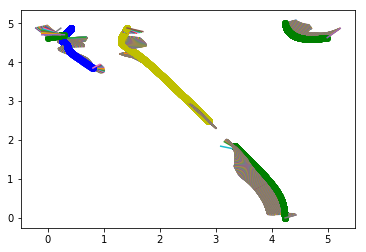

In [321]:
import copy as cp

delta_t = 1e-3
t_range = np.arange(0, 1500*delta_t, delta_t)

x = cp.deepcopy(x_init)
v = cp.deepcopy(v_init)

for t in t_range:
    delta_tot, r = particle_dist(L, N, x, dim)
    F, U = pot_and_force(delta_tot, r, dim, N)
    step_size = abs((v * delta_t)).any() > 0.3
    x += v * delta_t
    v += F * delta_t
    x[x > L] = (x[x > L]%L)
    x[x < 0] = abs((x[x < 0]%L))
    plt.plot(x[0,0],x[1,0],'go')
    plt.plot(x[0,1],x[1,1],'yo')
    plt.plot(x[0,2],x[1,2],'bo')
    
    if step_size:
        for i in range(N):
            plt.plot([x[0,i],x[0,i]+F[0,i]/sum(sum(abs(F)))],[x[1,i],x[1,i]+F[1,i]/sum(sum(abs(F)))])
            
plt.show()